# 1. Imports and installs

In [1]:
!pip install -q pycocotools --quiet

In [174]:
#Standard libraries
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import random
#Picture displaying
from matplotlib.patches import Polygon
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import zoom
#Model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
#Dataset
from pycocotools.coco import COCO

# 2. Dataset importation

In [3]:
#path to the annotations
annotations_path = Path('/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json')
#load the COCO api so we can work with the data
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=19.60s)
creating index...
index created!


### Chosing random 3000 cat and dog pictures

In [184]:
#we select random photos of cats and dogs and return their ids
def select_random_cat_and_dog_imgs():
    #get all pic ids with cats
    img_ids_cat = coco.getImgIds(catIds=coco.getCatIds(catNms=['cat']))
    #get all pic ids with dogs
    img_ids_dog = coco.getImgIds(catIds=coco.getCatIds(catNms=['dog']))

    #concatenate all of those ids
    img_ids_cat_dog = set(img_ids_cat) | set(img_ids_dog)

    #choose a random subset of the pictures
    subset_size = 100
    return random.sample(img_ids_cat_dog, min(subset_size, len(img_ids_cat_dog)))

In [185]:
selected_img_ids = select_random_cat_and_dog_imgs()

/tmp/ipykernel_47/3952498370.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(img_ids_cat_dog, min(subset_size, len(img_ids_cat_dog)))


# 3. Data analyzation

In [29]:
def show_picture(loaded_img):
    response = requests.get(loaded_img['coco_url'])
    image = Image.open(BytesIO(response.content))

    fig, ax = plt.subplots(1)

    ax.imshow(image)

    plt.show()

### Show us 5 random pictures with their segmentations

In [34]:
#shows one picture with all of its segmentations
#provide a loaded picture as the argument
def show_picture_and_segments(loaded_img):
    #get all the annotations for the image 
    annotations = coco.getAnnIds(loaded_img['id'])
    #so we can get all the segmentations here
    segmentations = [coco.anns[annotations[i]]['segmentation'] for i in range(len(annotations))]
    response = requests.get(loaded_img['coco_url'])
    image = Image.open(BytesIO(response.content))

    fig, ax = plt.subplots(1)

    ax.imshow(image)

    #this is where we add the segmentations for the picture
    for segmentation in segmentations:
        for poly in segmentation:
            xy = np.array(poly).reshape((len(poly) // 2, 2))
            polygon = Polygon(xy, edgecolor='r', fill=False)
            ax.add_patch(polygon)

    ax.axis('off')

    plt.show()

In [35]:
def show_random_5_images(img_ids):
    amount_of_imgs = 5
    #random starting index for 5 photos
    batch_start = random.randint(0,len(img_ids)-amount_of_imgs)
    #load them up
    imgs = coco.loadImgs(img_ids[batch_start:batch_start+amount_of_imgs])
    
    for img in imgs:
        show_picture_and_segments(img)

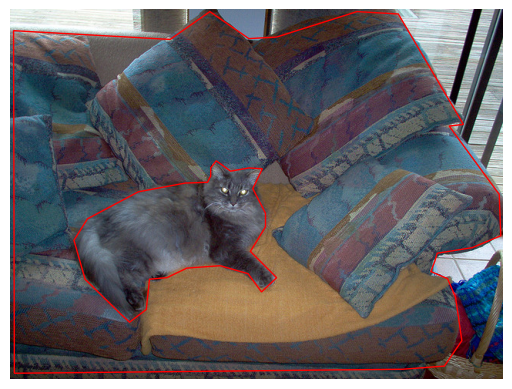

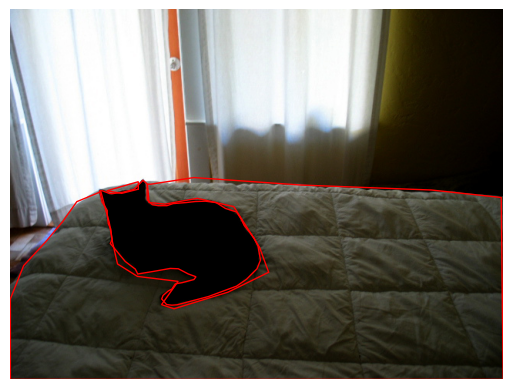

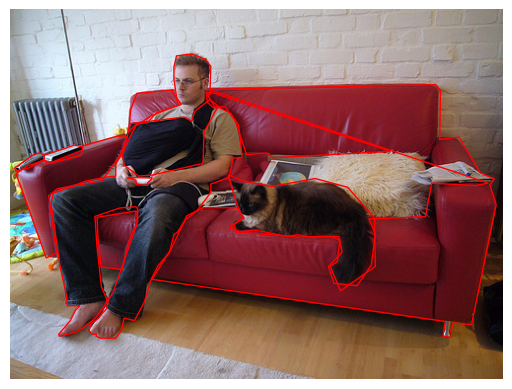

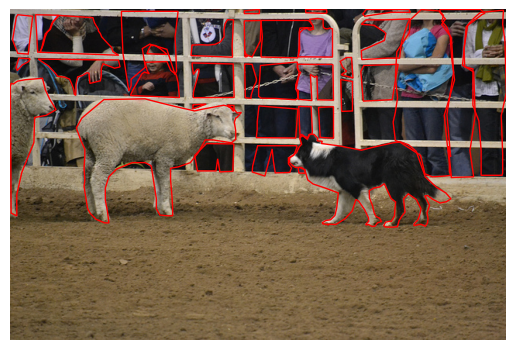

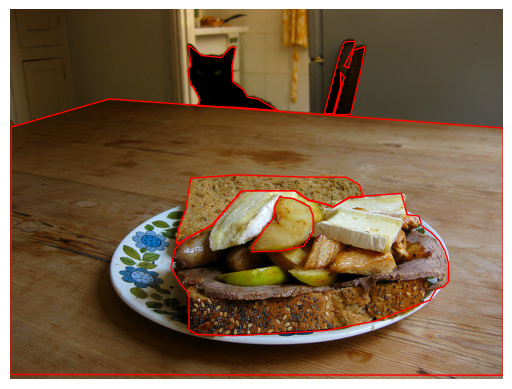

In [36]:
show_random_5_images(selected_img_ids)

### Sizes of pictures differ

Let's see what are the maximum widths and heights of pictures.

In [186]:
#load all selected images
all_imgs_loaded = coco.loadImgs(selected_img_ids)

In [188]:
#provide loaded imgs and this will give you 
#min, max width; min, max height respectively
def width_height_min_max(loaded_imgs):
    max_width = sys.maxsize*-1
    min_width = sys.maxsize
    max_height = sys.maxsize*-1
    min_height = sys.maxsize

    #go through all the pics and find max/min widths/heights
    for img in loaded_imgs:
        max_width = img['width'] if img['width'] > max_width else max_width
        min_width = img['width'] if img['width'] < min_width else min_width
        max_height = img['height'] if img['height'] > max_height else max_height
        min_height = img['height'] if img['height'] < min_height else min_height
        
    print('Minimal expected picture size is: {0}x{1}, and maximal expected picture size is: {2}x{3}'.format(min_width, min_height, max_width, max_height))
    return (min_width, max_width, min_height, max_height)

In [189]:
min_width, max_width, min_height, max_height = width_height_min_max(all_imgs_loaded)

Minimal expected picture size is: 374x253, and maximal expected picture size is: 640x640


We see that the pictures are of different sizes, we need to make them somehow equal so we can feed it to the model.<br>
The idea I suggest is filling the smaller pictures with 0's so they meet the size of bigger pictures.<br>

### The number of segmentations and their sizes differ as well

In [ ]:
first_pic_segmentation_ids = coco.getAnnIds(all_imgs_loaded[0]['id'])
print('The segmentation ids in the first picture are: {0}'.format(first_pic_segmentation_ids))

In [ ]:
second_pic_segmentation_ids = coco.getAnnIds(all_imgs_loaded[1]['id'])
print('and in the second one: {0}'.format(second_pic_segmentation_ids))

When we take a look above we see that the number of class segments for each of the pictures is different.<br>
The numbers represent ids for their segmentations. This tells us that pictures have different amounts of segments in them.<br>
Let's look a bit further.

In [ ]:
first_pic_segmentation_data_points = coco.anns[first_pic_segmentation_ids[0]]['segmentation']
print('The segmentation data points for the first picture are: {0}'.format(first_pic_segmentation_data_points))

In [ ]:
second_pic_segmentation_data_points = coco.anns[second_pic_segmentation_ids[0]]['segmentation']
print('and for the second picture they are: {0}'.format(second_pic_segmentation_data_points))

It is noticable that the pictures have different amounts of datapoints for their segments.<br>
Again we're gonna have to take care of that, and my suggestions is we to the same as for the sizes of the pictures.<br>
That's right *Zero padding* ;)<br><br>
PS: later i found out a better approach, we can create masks...the creators of the dataset didn't make it easy finding out the documentation ;(<br>
You'l find the details later.

# 4. Data preprocessing

In [190]:
#These values will be used for the size of the preprocessed data
#and input size for the model
desired_width = 64
desired_height = 64
#3 RGB(False) layers or 1(True)
grayscale = True

In [191]:
#this function will load up all the images we select and scale them, remove colors ecc..
#based on the settings
#it will also make coresponding masks which we will use for labels (the thing the model will learn)
#provide loaded images via the coco.loadImgs() function
def preprocess_features_and_labels(loaded_imgs, max_width=640, max_height=640, desired_output_width=64, desired_output_height=64, scale=False, zero_pad=False, grayscale=True):
    #request all the images based on their url
    responses = [requests.get(loaded_img['coco_url']) for loaded_img in loaded_imgs]
    #open all the images
    imgs = [Image.open(BytesIO(response.content)).resize((desired_output_width, desired_output_height)) if scale else Image.open(BytesIO(response.content)) for response in responses]
    
    #LABELS PREPROCESSING
    #get the annotations for the images so we can get their segmentations
    annotations = [coco.loadAnns(coco.getAnnIds(img['id'])) for img in loaded_imgs]
    #get the segmentations for the images and make masks which we will use as labels
    #the filter will contain the category id where the certain category is present and 0's otherwise
    segmentation_masks = [[coco.annToMask(segmentation)*segmentation['category_id'] for segmentation in annotation] for annotation in annotations]
    #we connect all the different masks into one mask
    segmentation_masks_merged = [np.maximum.reduce(masks) for masks in segmentation_masks]
    #resize the masks to match the pictures
    if scale:
        #we turned of the anti_aliasing property because we want the masks to be ints not floats or doubles
        #segmentation_masks_merged = [resize(mask, (desired_output_height, desired_output_width), anti_aliasing=False) for mask in segmentation_masks_merged]
        segmentation_masks_merged = [zoom(mask, (desired_output_height/mask.shape[0], desired_output_width/mask.shape[1]), order=0, mode='nearest') for mask in segmentation_masks_merged]

    #here comes the zero padding we were talking about earlier
    def zero_pad_img(img, zero_pad):
        image_to_be_processed = img
        
        if zero_pad:
            image_to_be_processed = np.zeros((max_width, max_height, 3))
            image_to_be_processed[:img.shape[0],:img.shape[1],:] = img
            
        return image_to_be_processed
    
    #zero pad the masks if the zero_pad is set to True
    def zero_pad_mask(mask, zero_pad):
        mask_to_be_processed = mask

        if zero_pad:
            mask_to_be_processed = np.zeros((max_width, max_height))
            mask_to_be_processed = np.maximum.reduce(np.array([mask, mask_to_be_processed]))
            
        return mask_to_be_processed
                       
    #transfer all the images into array forms and padd them with zeros
    #to fit the max_width and max_height
    imgs_array_form = [zero_pad_img(image.img_to_array(img)/255, zero_pad) for img in imgs] 
    segmentation_masks_merged = [zero_pad_mask(mask, zero_pad) for mask in segmentation_masks_merged] 
                 
    #if you want the picture without colors
    if grayscale:
        imgs_array_form = np.mean(imgs_array_form, axis=3, keepdims=True)

    return imgs_array_form, segmentation_masks_merged

In [192]:
x, Y = preprocess_features_and_labels(all_imgs_loaded, max_width, max_height, desired_width, desired_height, scale=True, grayscale=grayscale)

In [107]:
#this function shows us the original image and its segmentations
#as well as the preprocessed image and the preprocessed mask for it
#which we will give the model to learn
def show_preprocessed_image_and_mask(original_image, preprocessed_data):
    #preprocessed image
    img = preprocessed_data[0]
    #preprocessed mask for that image
    mask = preprocessed_data[1]
    
    #show the original image with original size
    show_picture(original_image)
    #show the original image with the segmentations
    show_picture_and_segments(original_image)
    
    #show the preprocessed image separately
    plt.title('The preprocessed image')
    plt.imshow(img, cmap='gray') 
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask separately
    plt.title('The preprocessed mask')
    ax.imshow(mask, alpha=0.3, extent=(0, mask.shape[1], mask.shape[0], 0))
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask and image together
    plt.title('The preprocessed mask on top of the preprocessed image')
    ax.imshow(img, cmap='gray')
    ax.imshow(mask, alpha=0.3, extent=(0, mask.shape[1], mask.shape[0], 0))

    plt.show()

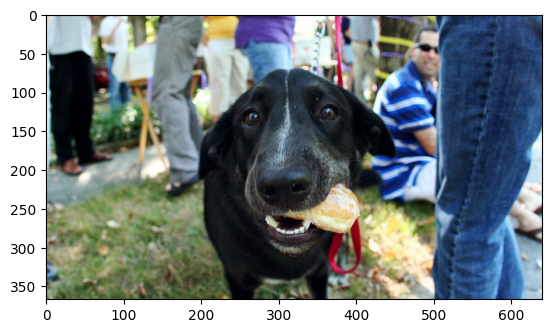

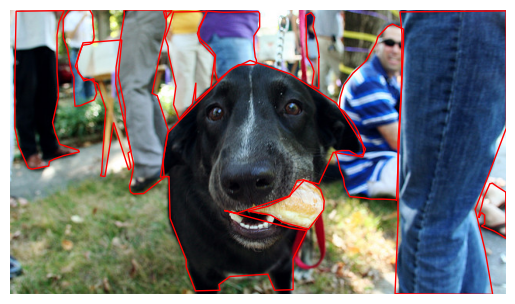

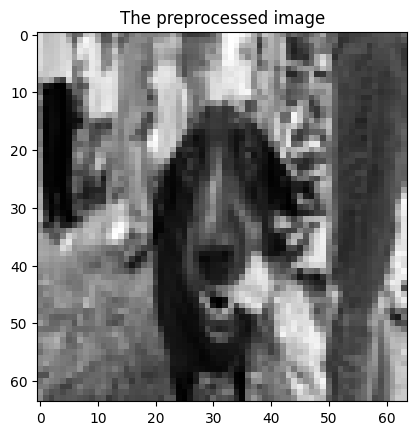

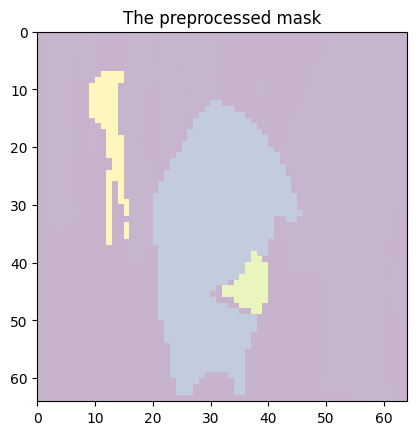

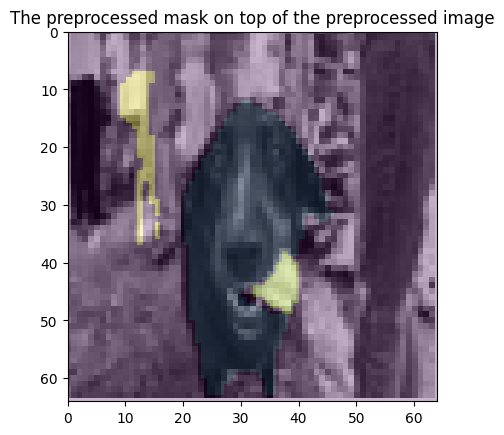

In [108]:
show_preprocessed_image_and_mask(all_imgs_loaded[0], (x[0], Y[0]))

Now after all of that data processing we have a preprocessed pictures and a preprocessed masks which we will try to teach the model.<br>
We do this because the model should be able to learn the correlations of the mask and the picture better with this spatial features.<br>
This is the better method I was talking about. First i wanted to teach the model the datapoints of the segmentations or the line that<br>
runs around objects in the picture, but then I realised it would be a lot better if I made masks which the model could learn. This will<br>
also give us the opportunity to make a <b>Fully Convolutional Neural Network<b>.

## Train/validation data split

In [205]:
def train_val_split(x, Y, split_rate=0.2):
    train_x = x[:round(len(x)*(1-split_rate))]
    val_x = x[round(len(x)*(1-split_rate)):]
    train_Y = Y[:round(len(Y)*(1-split_rate))]
    val_Y = Y[round(len(Y)*(1-split_rate)):]
    
    return train_x, train_Y, val_x, val_Y

In [270]:
train_x, train_Y, val_x, val_Y = train_val_split(x, Y)

In [271]:
#resolving some data problem 
#train_x and train_Y are not of same shape
train_Y = np.asarray(train_Y)
val_Y = np.asarray(val_Y)

print('Shape of train_x before: {0}'.format(train_x.shape))
print('Shape of train_Y before: {0}\n'.format(train_Y.shape))
print('Shape of val_x before: {0}'.format(val_x.shape))
print('Shape of val_Y before: {0}\n'.format(val_Y.shape))

train_Y = np.expand_dims(train_Y, axis=3)
val_Y = np.expand_dims(val_Y, axis=3)

print('Shape of train_x after: {0}'.format(train_x.shape))
print('Shape of train_Y after: {0}\n'.format(train_Y.shape))
print('Shape of val_x after: {0}'.format(val_x.shape))
print('Shape of val_Y after: {0}'.format(val_Y.shape))

Shape of train_x before: (80, 64, 64, 1)
Shape of train_Y before: (80, 64, 64)

Shape of val_x before: (20, 64, 64, 1)
Shape of val_Y before: (20, 64, 64)

Shape of train_x after: (80, 64, 64, 1)
Shape of train_Y after: (80, 64, 64, 1)

Shape of val_x after: (20, 64, 64, 1)
Shape of val_Y after: (20, 64, 64, 1)


# 5. The Model

In [302]:
input_shape = (desired_height, desired_width, 1)
if grayscale:
    input_shape=(desired_height, desired_width, 1)
    
def build_parsenet(input_shape=input_shape, num_classes=1):
    
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(16, 3, 2, padding='same', activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    up2 = Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(pool1)
    #conv2 = Conv2D(8, 3, 2, padding='same', activation='relu')(pool1)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    up3 = Concatenate()([up2, conv1])
    conv3 = Conv2D(8, 3, 2, padding='same', activation='relu')(up3)
    up4 = UpSampling2D(2)(up3)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='softmax')(up4)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [303]:
model = build_parsenet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_49 (Conv2D)          (None, 32, 32, 16)           160       ['input_24[0][0]']            
                                                                                                  
 max_pooling2d_31 (MaxPooli  (None, 16, 16, 16)           0         ['conv2d_49[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 16)           2320      ['max_pooling2d_31[0][0]

## Training

In [308]:
def train(model, train_x, train_Y, val_x, val_Y, epochs=10, batch_size=16):
    
    checkpoint = ModelCheckpoint(
            '',
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
    )

    history = model.fit(
        x=train_x,
        y=train_Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_x, val_Y)
    )
    
    return history

In [309]:
history = train(model, train_x, train_Y, val_x, val_Y,)

Epoch 1/10
5/5 [==============================] - 0s 35ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 2/10
5/5 [==============================] - 0s 23ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 4/10
5/5 [==============================] - 0s 23ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 6/10
5/5 [==============================] - 0s 23ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278
Epoch 7/10
5/5 [==============================] - 0s 23ms/step - loss: 831.1525 - accuracy: 0.0204 - val_loss: 612.2608 - val_accuracy: 0.0278

# 6. Results

In [291]:
def plot_model_metrics(history):
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.legend()
    plt.show()

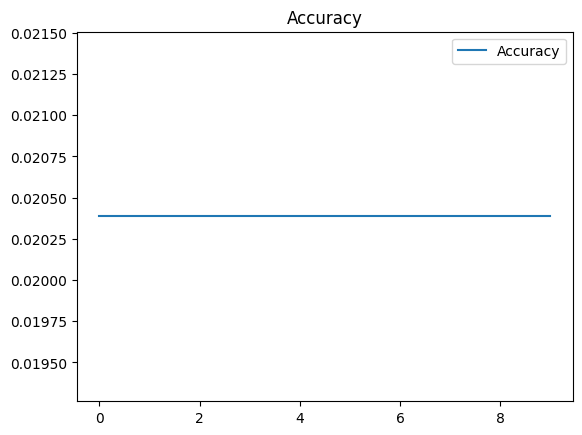

In [307]:
plot_model_metrics(history)

## The actual image

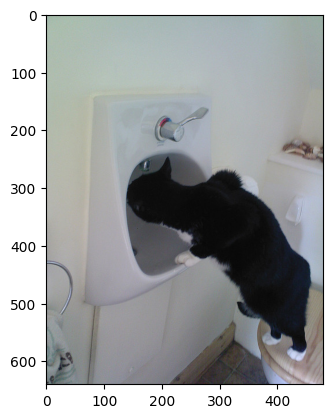

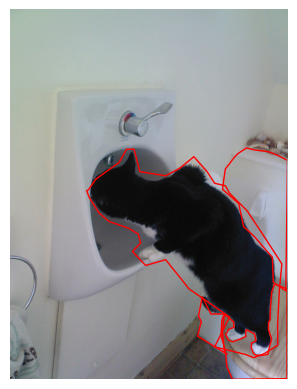

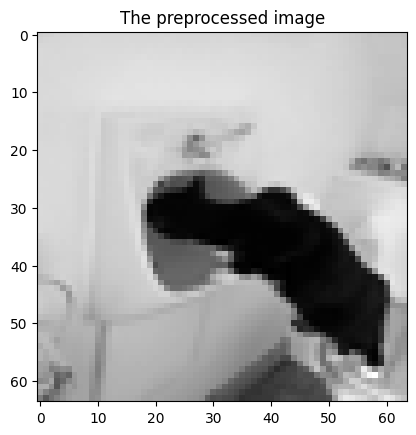

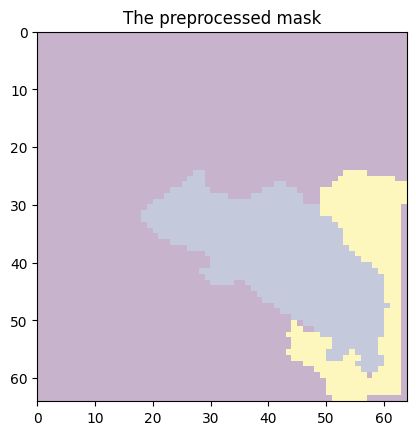

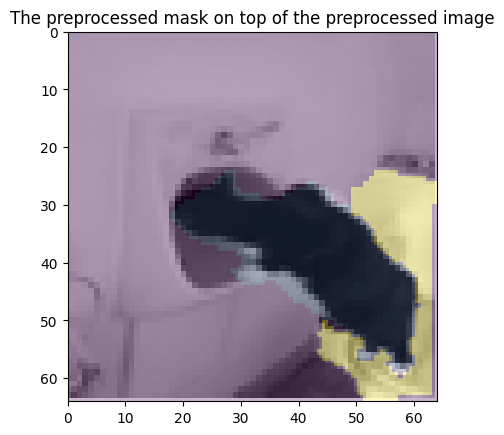

In [293]:
show_preprocessed_image_and_mask(all_imgs_loaded[0], (x[0], Y[0]))

## What the model learned

In [337]:
def model_prediction_visualization(img_index_in_train):
    img = train_x[img_index_in_train]
    prediction = model.predict(np.array([train_x[img_index_in_train]]))[0]
    
    fig, ax = plt.subplots()
    
    #show the preprocessed mask and image together
    plt.title('The original image, and model mask prediction above it')
    ax.imshow(img, cmap='gray')
    ax.imshow(prediction, alpha=0.3, extent=(0, prediction.shape[1], prediction.shape[0], 0))

    plt.show()

1/1 [==============================] - 0s 19ms/step


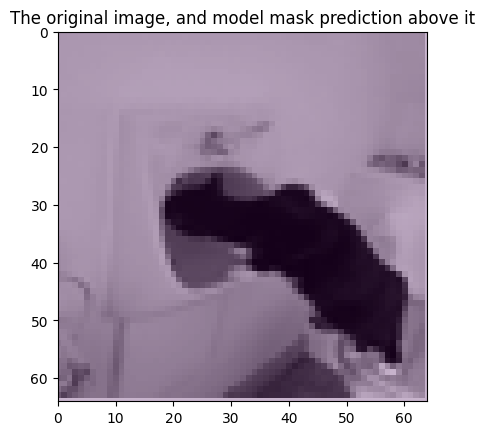

In [338]:
model_prediction_visualization(0)